In [1]:
import os
import numpy as np
from torch.utils.data import Dataset , DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
LR = 3e-4
EPOCHS = 20
NUM_WORKERS = os.cpu_count()
IMG_CHANNELS = 3

In [2]:
low_res_size = 128
high_res_size = 256

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size , low_res_size)),
    transforms.ToTensor()
])
transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size , high_res_size)),
    transforms.ToTensor()
])

In [3]:
#Creating custom dataset
class ImageDataset(Dataset):
    def __init__(self , root_dir):
        super(ImageDataset , self).__init__()
        self.data = []
        self.root_dir = root_dir
        files_low = os.listdir(os.path.join(root_dir , "low_res"))
        files_high = os.listdir(os.path.join(root_dir , "high_res"))
        self.data = list(zip(files_low , files_high))
    def __len__(self):
        return len(self.data)
    def __getitem__(self , index):
        img_low_file , img_high_file = self.data[index]
        #Get the path for the image Low res and High Res
        low_res_pth = os.path.join(self.root_dir , "low_res" , img_low_file)
        high_res_pth = os.path.join(self.root_dir , "high_res" , img_high_file)
        #Open the actual image
        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))
        
        #Discard the alpha channel to make the model more optimized for memory
        low_res = low_res[:,:,:3]
        high_res = high_res[:,:,:3]
        
        #Apply the transformation for the image
        low_res = transform_low(low_res)
        high_res = transform_high(high_res)
        
        return low_res , high_res

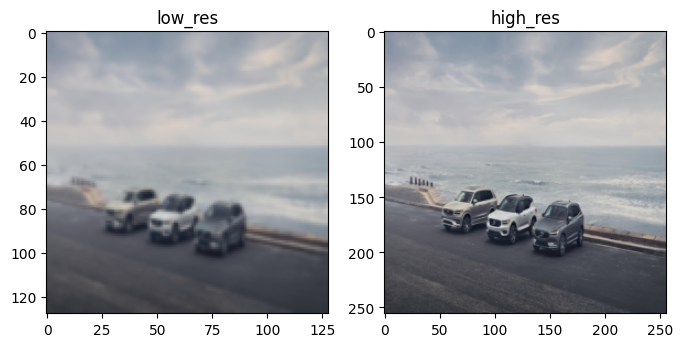

In [4]:
#Showing the image from the dataset
def show_image():
    dataset = ImageDataset(root_dir = "/kaggle/input/image-super-resolution/dataset/train")
    loader = DataLoader(dataset , batch_size = 32 , num_workers = NUM_WORKERS)
    #Create a figure with two subplots
    fig , axs = plt.subplots(1,2,figsize = (8,4))
    for idx , (low_res , high_res) in enumerate(loader):
        #Display the first image in the left subplot
        axs[0].imshow(low_res[0].permute(1,2,0))
        axs[0].set_title("low_res")
        #Display the second image in the left subplot
        axs[1].imshow(high_res[0].permute(1,2,0))
        axs[1].set_title("high_res")
        if(idx == 1): #Display only the first image from the batch
            break
    plt.show()
show_image()

In [5]:
#Creating a feature extractor class and calculate their perceptual loss
test_vgg_model = vgg19(weights = True).eval().to(device)
lf = list(test_vgg_model.features)
lf[25]

class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained = True).features[:25].eval().to(device)
        #Taking the convolutional feature extractor part
        self.loss = nn.MSELoss() #Calculate perceptual loss
    def forward(self , first , second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first , vgg_second)
        return perceptual_loss

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 166MB/s] 


In [6]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels , out_channels , 
                use_activation = True , use_BatchNorm = True , **kwargs):
        super().__init__()
        self.use_activation = use_activation
        self.cnn = nn.Conv2d(in_channels , out_channels , **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.ac = (nn.LeakyReLU(0.2 , inplace = True))
    def forward(self , x):
        x1 = self.cnn(x)
        x2 = self.bn(x1)
        x3 = self.ac(x2)
        return x3 if self.use_activation else x2

In [7]:
class UpsampleBlock(nn.Module):
    def __init__(self , in_channels , scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels , in_channels*scale_factor**2,2,1,1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters = in_channels)
    def forward(self , x):
        return self.ac(self.ps(self.conv(x)))

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(in_channels , in_channels , kernel_size = 3,
                           stride = 1, padding = 1)
        self.b2 = ConvBlock(in_channels , in_channels , kernel_size = 3 ,
                           stride = 1,
                           padding = 1,
                           use_activation = False)
    def forward(self , x):
        out = self.b1(x)
        out = self.b2(out)
        return out*x

In [9]:
#Define generator model which learns to generate data that resemble
#real data samples
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for i in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2)) 
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        return torch.sigmoid(self.final(c))

#Define discriminator which learns to differentiates between real data 
#samples and fake samples generated by the generator
class Discriminator(nn.Module):
    def __init__(self , in_channels = 3 , features = [64 , 64 , 128 , 128 , 256
                                                     ,256 , 512 , 512]):
        super().__init__()
        blocks = []
        for idx , feature in enumerate(features):
            blocks.append(ConvBlock(in_channels , feature , kernel_size = 3, 
                                   stride = idx%2+1,padding = 1,
                                   use_activation = True , 
                                   use_BatchNorm = idx != 0))
            in_channels = feature
        self.blocks = nn.Sequential(*blocks)
        self.mlp = nn.Sequential(
        nn.AdaptiveAvgPool2d((8,8)),
        nn.Flatten(),
        nn.Linear(512*8*8,1024),
        nn.LeakyReLU(0.2 , inplace = True),
        nn.Linear(1024,1))
    def forward(self , x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x

In [10]:
def plot_examples(gen):
    dataset_test = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/val")
    loader = DataLoader(dataset_test, batch_size=16, num_workers=2)
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    chosen_batch = random.randint(0, len(loader)-1)
    for idx, (low_res, high_res) in enumerate(loader):
        if(chosen_batch == idx):
            chosen = random.randint(0, len(low_res)-1)
        
            axs[0].set_axis_off()
            axs[0].imshow(low_res[chosen].permute(1, 2, 0))
            axs[0].set_title("low res")

            with torch.no_grad():
                upscaled_img = gen(low_res[chosen].to(device).unsqueeze(0))
        
            axs[1].set_axis_off()
            axs[1].imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
            axs[1].set_title("predicted")
        
            axs[2].set_axis_off()
            axs[2].imshow(high_res[chosen].permute(1, 2, 0))
            axs[2].set_title("high res")
        
            if(idx == 1): #Display one image from the batch which is at idx 0
                break
            
    # Show the figure
    plt.show()      
    
    gen.train()

In [11]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_progress(epoch , num_epochs , d_losses , g_losses):
    clear_output(wait = True)
    plt.figure(figsize = (10,5))
    plt.title("Training Progress")
    plt.plot(d_losses , label = "Discriminator Loss")
    plt.plot(g_losses , label = "Generator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print(f"Epoch [{epoch}/{num_epochs}], Discriminator loss: {d_losses[-1]:.4f}, Generator loss: {g_losses[-1]:.4f}")

In [12]:
#Define the generator , discriminator , and other hyperparameters 
gen = Generator(in_channels = 3).to(device)
disc = Discriminator(in_channels = 3).to(device)
opt_gen = optim.Adam(gen.parameters() , lr = LR , betas = (0.9 , 0.999))
opt_disc = optim.Adam(disc.parameters() , lr = LR , betas = (0.9 , 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


In [13]:
train = ImageDataset(root_dir = "/kaggle/input/image-super-resolution/dataset/train")
train_dataloader = DataLoader(train , batch_size = BATCH_SIZE 
                              , num_workers = NUM_WORKERS)
val = ImageDataset(root_dir = "/kaggle/input/image-super-resolution/dataset/val")
val_dataloader = DataLoader(val , batch_size = BATCH_SIZE , 
                       num_workers = NUM_WORKERS)

def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    disc_loss = 0
    gen_loss = 0
    for batch , (x,y) in tqdm(enumerate(train_dataloader)):
        
        x,y = x.to(device) , y.to(device)
        #Training Discriminator
        fake = gen(x)
        
        disc_real = disc(y)
        disc_fake = disc(fake.detach())
        
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        
        disc_loss = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Train Generator
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, y)
        gen_loss = loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

            
    return gen_loss.detach().cpu(), disc_loss.detach().cpu()

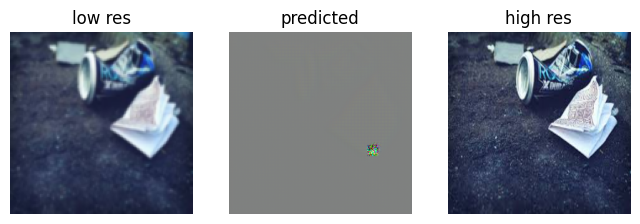

Epoch : 1 /20


0it [00:00, ?it/s]

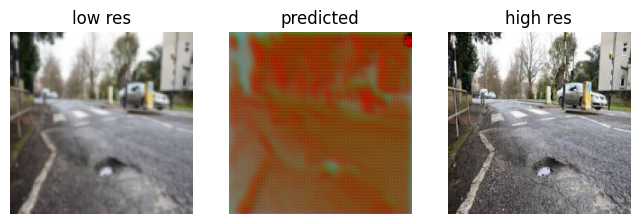

Epoch : 2 /20


0it [00:00, ?it/s]

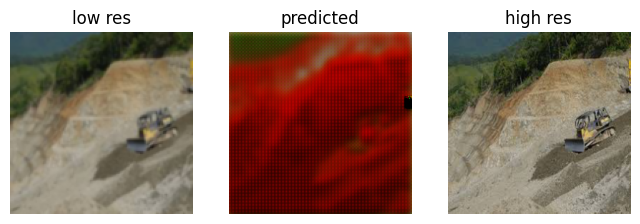

Epoch : 3 /20


0it [00:00, ?it/s]

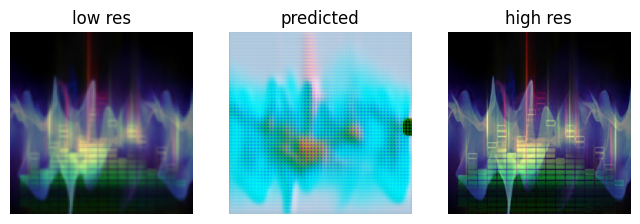

Epoch : 4 /20


0it [00:00, ?it/s]

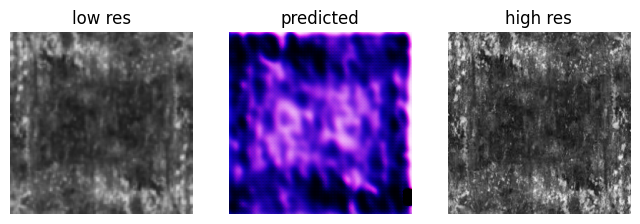

Epoch : 5 /20


0it [00:00, ?it/s]

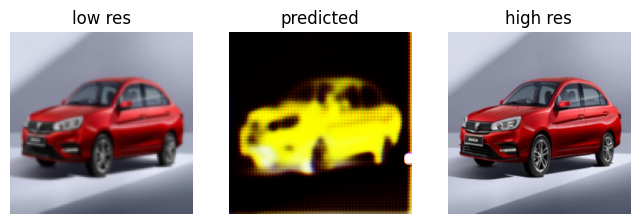

Epoch : 6 /20


0it [00:00, ?it/s]

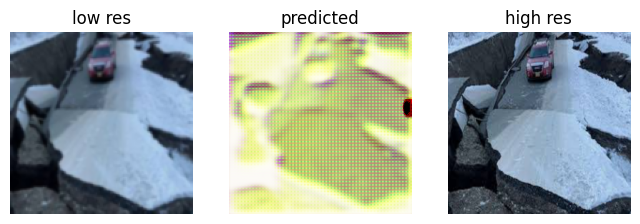

Epoch : 7 /20


0it [00:00, ?it/s]

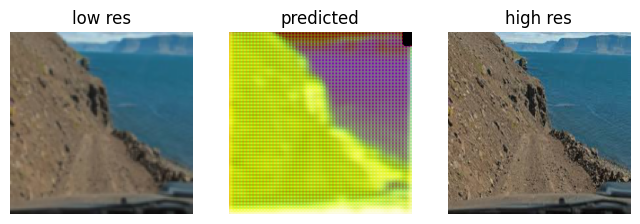

Epoch : 8 /20


0it [00:00, ?it/s]

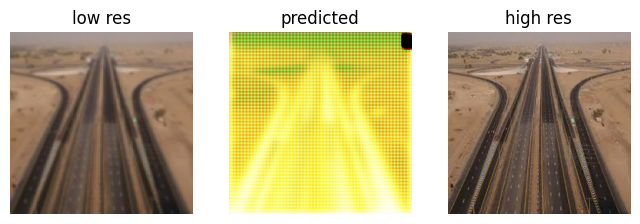

Epoch : 9 /20


0it [00:00, ?it/s]

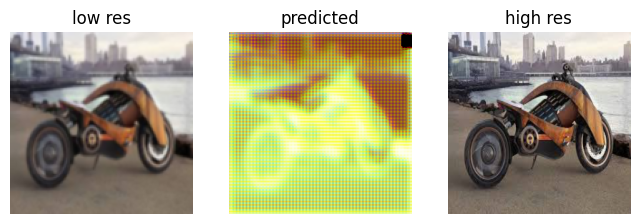

Epoch : 10 /20


0it [00:00, ?it/s]

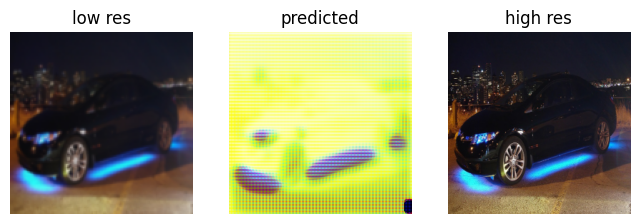

Epoch : 11 /20


0it [00:00, ?it/s]

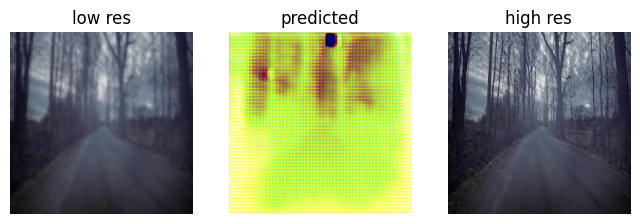

Epoch : 12 /20


0it [00:00, ?it/s]

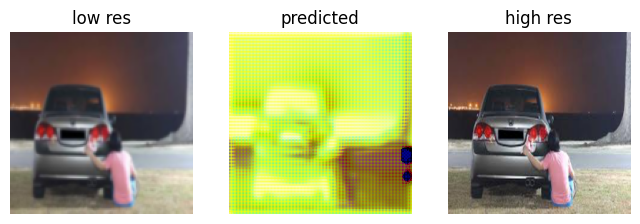

Epoch : 13 /20


0it [00:00, ?it/s]

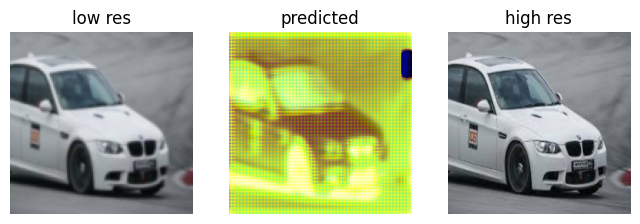

Epoch : 14 /20


0it [00:00, ?it/s]

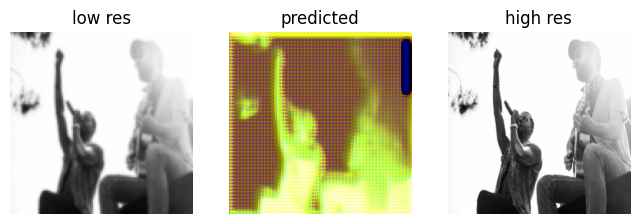

Epoch : 15 /20


0it [00:00, ?it/s]

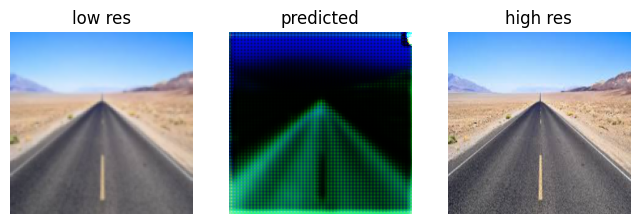

Epoch : 16 /20


0it [00:00, ?it/s]

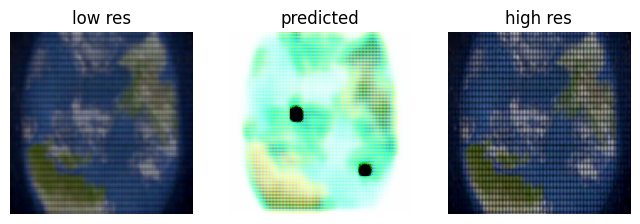

Epoch : 17 /20


0it [00:00, ?it/s]

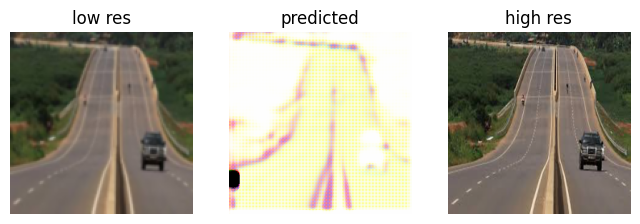

Epoch : 18 /20


0it [00:00, ?it/s]

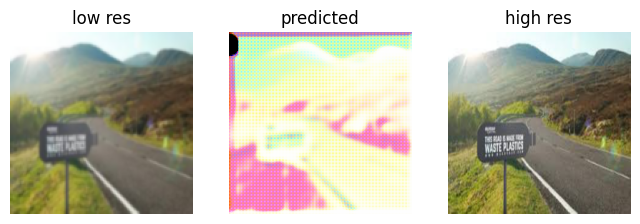

Epoch : 19 /20


0it [00:00, ?it/s]

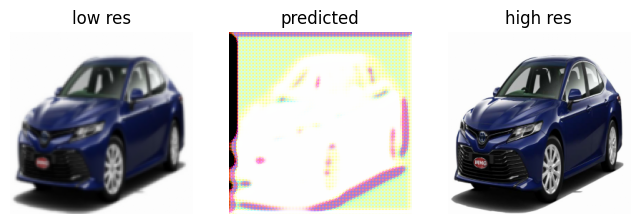

Epoch : 20 /20


0it [00:00, ?it/s]

In [14]:
d_losses = []
g_losses = []
for epoch in range(EPOCHS):
    plot_examples(gen)
    print(f"Epoch : {epoch + 1}" , f"/{EPOCHS}")
    gen_loss , disc_loss = train_fn(train_dataloader , disc , gen , opt_gen ,
                                   opt_disc , mse , bce , vgg_loss)
    #Train discriminator and generator and update losses
    d_losses.append(disc_loss)
    g_losses.append(gen_loss)

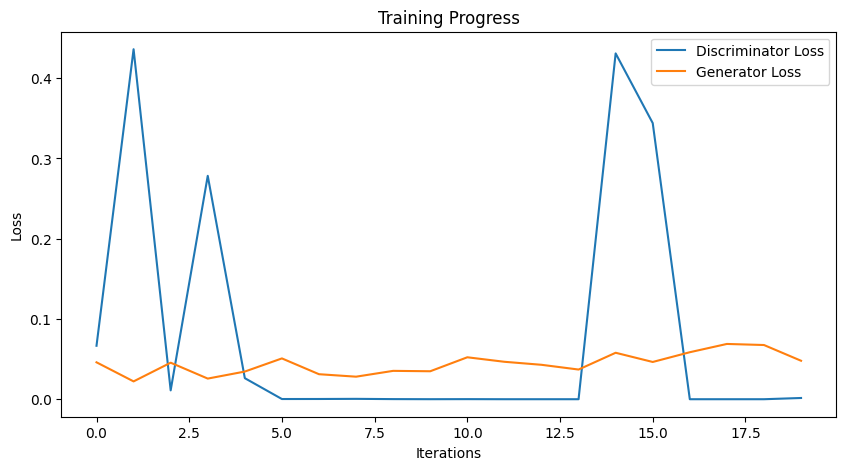

Epoch [19/20], Discriminator loss: 0.0015, Generator loss: 0.0479


In [15]:
#Print Progress
plot_examples(gen)
train_progress(epoch , EPOCHS , d_losses , g_losses)